# Analysis of Rolling Sales Data - Queens

# Steps

I am going to do the following:

    1. Import necessary modules
    2. Load the prepped data per borough 
    3. Analyze the data for trends and seasonality
    4. Dickey-Fuller Tests and preparing data for ARMA modeling by inducing stationarity
    5. ARMA model of the data
    6. Error analysis of the ARMA model
    7. Comparison with latest data
    8. Onservations/Conclusions

## 1. Imports

In [1]:
import pandas as pd
from pandas.plotting import register_matplotlib_converters
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import datetime
from statsmodels.tsa.arima_model import ARMA
from statsmodels.tsa.stattools import adfuller, acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose
import numpy as np
from matplotlib.pylab import rcParams
from sklearn.metrics import mean_squared_error
from math import sqrt

## 2. Loading the prepared data

##### Observations: 
 - Once I loaded the data and sorted it, the SALE DATE values range from 4/1/2020 until 3/31/2021.
 - This data was the most recent data when I started working on the project. 
 - NYC OpenData website updates this data regularly with newer months about every 2-3 months

In [2]:
df = pd.read_csv('rollingsales_queens.xls_prepped_bare.csv')
df.reset_index(drop=True, inplace=True)
df.sort_values('SALE DATE')

,TAX CLASS AT PRESENT,ZIP CODE,SALE PRICE,SALE DATE
11776,1,11434,434500,2020-04-01
5303,2,11375,1150000,2020-04-01
10406,4,11418,2500000,2020-04-01
11814,1,11434,358000,2020-04-01
12658,1,11357,720000,2020-04-01
...,...,...,...,...
13114,2,11377,370000,2021-03-31
10094,1,11418,773800,2021-03-31
5566,2,11004,167600,2021-03-31
5156,2,11375,425000,2021-03-31


## 3. Analyzing the data for trends/seasonality

I do the following steps here to help the data work with the modules:

    1. Convert 'SALE DATE' column to datetime format
    2. Create new dataframe with 'SALE DATE' as the index and 'SALE PRICE' as the column
    3. Since we have multiple sales per day, I will aggregate the data into daily data by taking the daily average of sales
    4. Check the data for any nulls/NaNs
    5. Use statsmodels to observe the data for trends and seasonality
    
##### Observations:
    - NaN values came into the data after the data got aggregated. 
    - Upon further inspection, this was due to the 70 days of no sales in the origional data. 
    - Thus, after aggregation, there were 70 days with no data, which I dropped

In [3]:
# Convert 'SALE DATE' column to datetime format
df['SALE DATE'] = pd.to_datetime(df['SALE DATE'])

In [4]:
# Create new dataframe with 'SALE DATE' as the index and 'SALE PRICE' as the column
df_price_date = pd.DataFrame(df, columns=['SALE DATE', 'SALE PRICE'])
df_price_date = df_price_date.set_index('SALE DATE')
df_price_date.head()

,SALE PRICE
SALE DATE,
2020-07-16,4121000
2020-08-28,584569
2021-01-11,800000
2020-12-16,300000
2020-06-23,360000


In [5]:
#Group the sales data by daily average
df_price_date = df_price_date.resample('D').mean()

In [6]:
# We see here number of rows went down from 13171 to 295. Why wasn't it 365 rows to represent all days of the year?
df_price_date.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 365 entries, 2020-04-01 to 2021-03-31
Freq: D
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   SALE PRICE  295 non-null    float64
dtypes: float64(1)
memory usage: 5.7 KB


In [7]:
#Here we see that since we resampled by day, there are NaN values for the days that there were no sales due to no sale date, pandas autofilled it with NaN
df_price_date['SALE PRICE'].isna().sum()

70

In [8]:
df_price_date.dropna(inplace=True)
df_price_date

,SALE PRICE
SALE DATE,
2020-04-01,961150.000000
2020-04-02,753357.142857
2020-04-03,681724.206897
2020-04-06,725208.000000
2020-04-07,630053.736842
...,...
2021-03-25,609609.756098
2021-03-26,652589.285714
2021-03-29,694114.470588


In [9]:
# df_price_date.rolling(window=2).mean().head()
df_price_date['roll_avg'] = df_price_date.rolling(window=7).mean()
df_price_date

,SALE PRICE,roll_avg
SALE DATE,,
2020-04-01,961150.000000,NaN
2020-04-02,753357.142857,NaN
2020-04-03,681724.206897,NaN
2020-04-06,725208.000000,NaN
2020-04-07,630053.736842,NaN
...,...,...
2021-03-25,609609.756098,560096.239773
2021-03-26,652589.285714,548271.167382
2021-03-29,694114.470588,559603.341147


I plotted the data here against its 7 day rolling average to see if I can discern any pattern

Text(0, 0.5, 'Average Price')

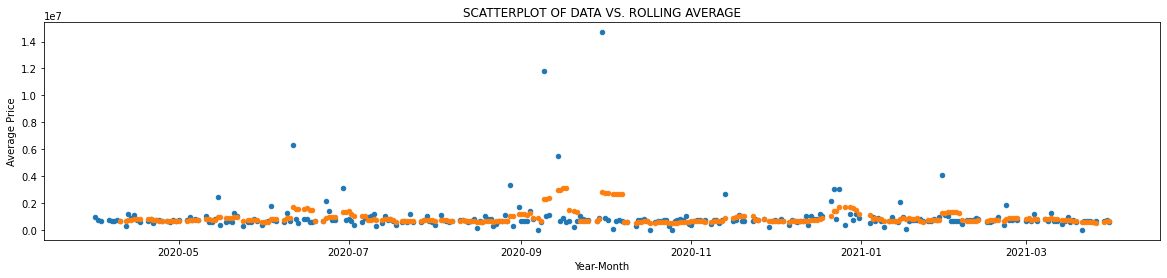

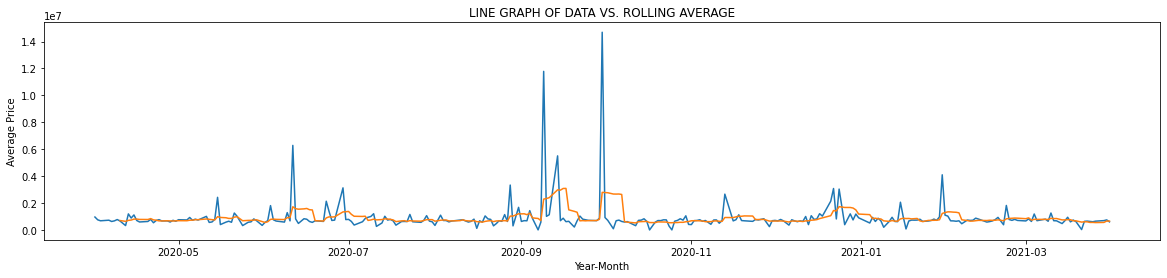

In [10]:
plt.figure(figsize=(20, 4))
plt.title("SCATTERPLOT OF DATA VS. ROLLING AVERAGE")
plt.xlabel("Year-Month")
plt.ylabel("Average Price")
#s=20 to keep dots small in size
plt.scatter(df_price_date.index[:295], df_price_date['SALE PRICE'][:295], s=20)
plt.scatter(df_price_date.index[7:], df_price_date['roll_avg'][7:], s=20);
plt.figure(figsize=(20, 4))
plt.title("LINE GRAPH OF DATA VS. ROLLING AVERAGE")
plt.plot(df_price_date.index[:295], df_price_date['SALE PRICE'][:295])
plt.plot(df_price_date.index[7:], df_price_date['roll_avg'][7:]);
plt.xlabel("Year-Month")
plt.ylabel("Average Price")

In [11]:
# Statsmodels
decomposition = seasonal_decompose(df_price_date['SALE PRICE'], model='multiplicative', period=30)
observed = decomposition.observed
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

In [12]:
register_matplotlib_converters()

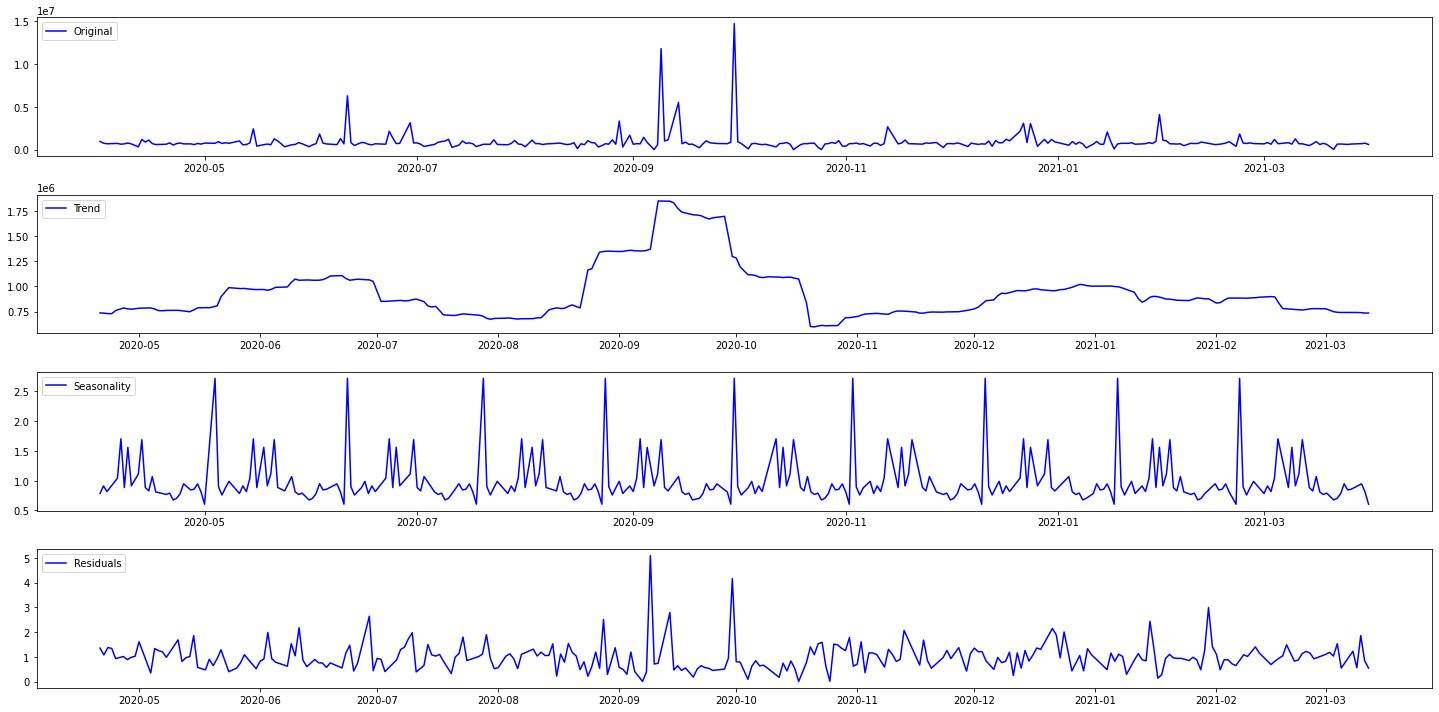

In [13]:
plt.figure(figsize=(20,10))
plt.subplot(411)
plt.plot(observed, label='Original', color="blue")
plt.legend(loc='upper left')
plt.subplot(412)
plt.plot(trend, label='Trend', color="blue")
plt.legend(loc='upper left')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality', color="blue")
plt.legend(loc='upper left')
plt.subplot(414)
plt.plot(residual, label='Residuals', color="blue")
plt.legend(loc='upper left')
plt.tight_layout()

##### Observations: 
 - A large amount of sales happened between August 2020 and November 2020. 
 - There was some seasonality that happened once a month and in the middle of the month

## 4. Dickey-Fuller Tests and preparing data for ARMA modeling by inducing stationarity

I had to do the following to induce stationarity:

In [14]:
# Initial test
dftest = adfuller(df_price_date['SALE PRICE'])
dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
for key,value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value
print(dftest)
print()
print(dfoutput)

(-2.6447743906943435, 0.08409181983183306, 15, 279, {'1%': -3.4540076534999957, '5%': -2.8719557347997178, '10%': -2.5723200648758366}, 8581.215834206878)

Test Statistic                  -2.644774
p-value                          0.084092
#Lags Used                      15.000000
Number of Observations Used    279.000000
Critical Value (1%)             -3.454008
Critical Value (5%)             -2.871956
Critical Value (10%)            -2.572320
dtype: float64


### Augmented Dickey Fuller Test Goals: 

Our goal is to induce stationarity and show that the data does not have a unit root. 

ADF Test Null Hypothesis: The data has a unit root and is non-stationary.

Requirements for stationarity:

    1. If p-value <= 0.05: Reject the null hypothesis (H0), the data does not have a unit root and is stationary.
        - If p-value > 0.05: Fail to reject the null hypothesis (H0), the data has a unit root and is non-stationary.
    2. If the Test Statistic is lower than the critical values, then reject the null hypothesis. Data does not have a unity root and is stationary


### Results of ADF Test

<b><u>Test Statistic vs. Critical Values</b></u>
- Initial test shows Test Statistic of **-2.6448**, this is greater than the critical values for 1% and 5%.
    - <i>We fail to reject the null hypothesis that the time series is not stationary!</i>

<b><u>P-Value Analysis</b></u>


- Our current p-value is **0.084092**
    - <i>This means: p-value > 0.05: Fail to reject the null hypothesis (H0), the data has a unit root and is non-stationary.</i>

In [15]:
#Logging the data and then rerunning ADF test
df_price_date_diff= df_price_date.diff(periods=12)
# df_price_date['SALE_PRICE_LOGGED'] = df_price_date['SALE PRICE'].apply(lambda x : np.log(x))

In [16]:
df_price_date['SALE_PRICE_LOGGED']

SALE DATE
2020-04-01    13.775886
2020-04-02    13.532295
2020-04-03    13.432380
2020-04-06    13.494214
2020-04-07    13.353560
                ...    
2021-03-25    13.320574
2021-03-26    13.388703
2021-03-29    13.450392
2021-03-30    13.524638
2021-03-31    13.308270
Name: SALE_PRICE_LOGGED, Length: 295, dtype: float64

Text(0, 0.5, 'Average Price')

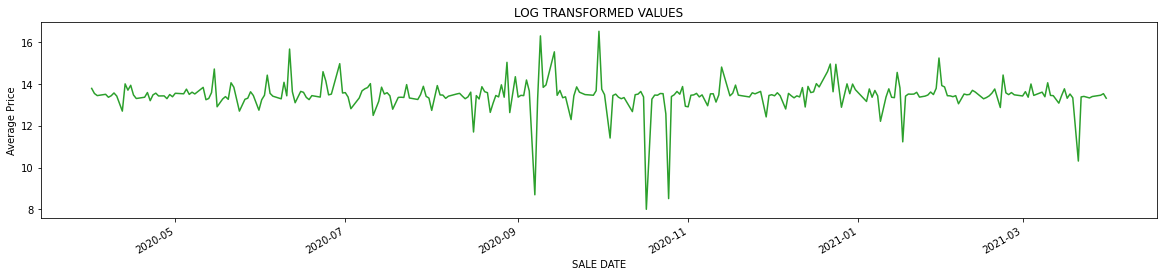

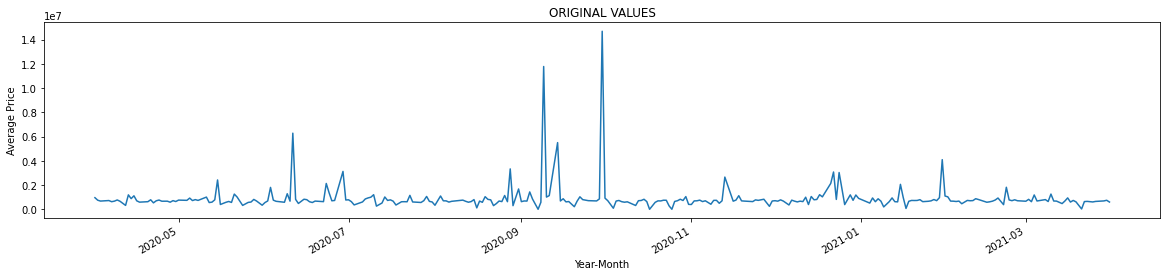

In [17]:
plt.figure(figsize=(20, 4))
# plt.title("SCATTERPLOT OF DATA VS. ROLLING AVERAGE")
plt.xlabel("Year-Month")
plt.ylabel("Average Price")
#s=20 to keep dots small in size
df_price_date['SALE_PRICE_LOGGED'].plot(color="tab:green", title="LOG TRANSFORMED VALUES");

plt.figure(figsize=(20, 4))
plt.title("LINE GRAPH OF DATA VS. ROLLING AVERAGE")
df_price_date['SALE PRICE'].plot(color="tab:blue", title="ORIGINAL VALUES");
plt.xlabel("Year-Month")
plt.ylabel("Average Price")

In [18]:
# Initial test
dftest = adfuller(df_price_date['SALE_PRICE_LOGGED'])
dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
for key,value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value
print(dftest)
print()
print(dfoutput)

(-5.05375987391139, 1.7352444685703553e-05, 6, 288, {'1%': -3.453261605529366, '5%': -2.87162848654246, '10%': -2.5721455328896603}, 652.5902901266107)

Test Statistic                  -5.053760
p-value                          0.000017
#Lags Used                       6.000000
Number of Observations Used    288.000000
Critical Value (1%)             -3.453262
Critical Value (5%)             -2.871628
Critical Value (10%)            -2.572146
dtype: float64


### Results of ADF Test

<b><u>Test Statistic vs. Critical Values</b></u>
- Initial test shows Test Statistic of **-5.053760**, this is greater than the critical values for 1% and 5%.
    - <i>We **REJECT** the null hypothesis! The data does not have a unit root and is stationary</i>

<b><u>P-Value Analysis</b></u>


- Our current p-value is **0.000017**
    - <i>This means: p-value <= 0.05: </i>
    - <i>We **REJECT** the null hypothesis! The data does not have a unit root and is stationary</i>

## 5. ARMA MODELING

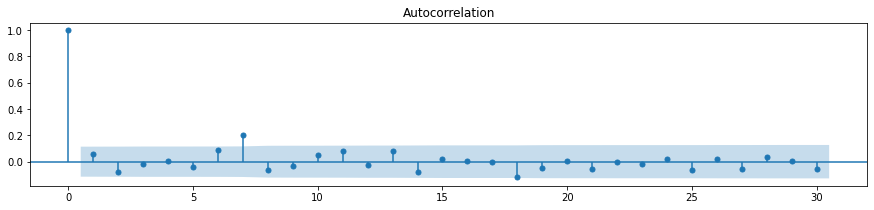

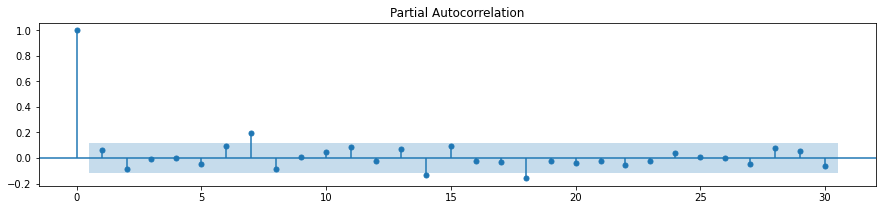

In [19]:
# ACF AND PACF

rcParams['figure.figsize'] = 15, 3
plot_acf(df_price_date['SALE_PRICE_LOGGED'], lags=30, alpha=0.05);

rcParams['figure.figsize'] = 15, 3
plot_pacf(df_price_date['SALE_PRICE_LOGGED'], lags=30, alpha=0.05);

In [20]:
# Instantiate & fit model with statsmodels
#p = num lags - ACF
p = 7

# q = lagged forecast errors - PACF
q = 7

#d = number of differences
d = 7


# Fitting ARMA model and summary
ar = ARMA(df_price_date['SALE_PRICE_LOGGED'],(p,d,q)).fit()
ar.summary()

C:\Users\booos\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
C:\Users\booos\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but 

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:      SALE_PRICE_LOGGED   No. Observations:                  295
Model:                     ARMA(7, 7)   Log Likelihood                -317.352
Method:                       css-mle   S.D. of innovations              0.690
Date:                Sat, 19 Jun 2021   AIC                            666.704
Time:                        20:59:48   BIC                            725.695
Sample:                             0   HQIC                           690.325
                                                                              
===========================================================================================
                              coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------
const                      13.4533      0.054    250.478      0.000      13.348      13.559
ar.L1.SALE_PRICE_LOGGED     0.0757      0.049      1.550      0.121      -0.020       0.171
ar.L2.SALE_PRICE_LOGGED     0.0255      0.049      0.518      0.604      -0.071       0.122
ar.L3.SALE_PRICE_LOGGED     0.4542      0.049      9.207      0.000       0.357       0.551
ar.L4.SALE_PRICE_LOGGED     0.3324      0.053      6.330      0.000       0.229       0.435
ar.L5.SALE_PRICE_LOGGED     0.0839      0.048      1.732      0.083      -0.011       0.179
ar.L6.SALE_PRICE_LOGGED     0.0165      0.050      0.328      0.743      -0.082       0.115
ar.L7.SALE_PRICE_LOGGED    -0.6656      0.048    -13.956      0.000      -0.759      -0.572
ma.L1.SALE_PRICE_LOGGED    -0.0067      0.032     -0.206      0.837      -0.070       0.057
ma.L2.SALE_PRICE_LOGGED    -0.0927      0.034     -2.763      0.006      -0.158      -0.027
ma.L3.SALE_PRICE_LOGGED    -0.4456      0.029    -15.362      0.000      -0.502      -0.389
ma.L4.SALE_PRICE_LOGGED    -0.4457      0.028    -16.163      0.000      -0.500      -0.392
ma.L5.SALE_PRICE_LOGGED    -0.0928      0.033     -2.796      0.005      -0.158      -0.028
ma.L6.SALE_PRICE_LOGGED    -0.0068      0.032     -0.212      0.832      -0.070       0.056
ma.L7.SALE_PRICE_LOGGED     0.9999      0.039     25.556      0.000       0.923       1.077
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1           -1.0973           -0.0000j            1.0973           -0.5000
AR.2           -0.6081           -0.8529j            1.0474           -0.3486
AR.3           -0.6081           +0.8529j            1.0474            0.3486
AR.4            0.1517           -1.0468j            1.0577           -0.2271
AR.5            0.1517           +1.0468j            1.0577            0.2271
AR.6            1.0174           -0.2835j            1.0561           -0.0433
AR.7            1.0174           +0.2835j            1.0561            0.0433
MA.1           -1.0000           -0.0000j            1.0000           -0.5000
MA.2           -0.5978           -0.8017j            1.0000           -0.3520
MA.3           -0.5978           +0.8017j            1.0000            0.3520
MA.4            0.1427           -0.9898j            1.0000           -0.2272
MA.5            0.1427           +0.9898j            1.0000            0.2272
MA.6            0.9585           -0.2851j            1.0000           -0.0460
MA.7            0.9585           +0.2851j            1.0000            0.0460
-----------------------------------------------------------------------------
"""

In [21]:
# start_index = len(df_price_date['SALE_PRICE_LOGGED'])
# end_index = start_index + 30
# forecast = ar.predict(start=start_index, end=end_index)
# start_index
# end_index

In [22]:
# dta.index = pd.date_range(start='1700', end='2009', freq='A')

# df_price_date.index= pd.to_datetime(df_price_date.index, format="%Y/%m/%d")

In [23]:
df_price_date.reset_index(inplace=True)

In [24]:
df_price_date.index

RangeIndex(start=0, stop=295, step=1)

In [25]:
df_price_date

,SALE DATE,SALE PRICE,roll_avg,SALE_PRICE_LOGGED
0,2020-04-01,961150.000000,NaN,13.775886
1,2020-04-02,753357.142857,NaN,13.532295
2,2020-04-03,681724.206897,NaN,13.432380
3,2020-04-06,725208.000000,NaN,13.494214
4,2020-04-07,630053.736842,NaN,13.353560
...,...,...,...,...
290,2021-03-25,609609.756098,560096.239773,13.320574
291,2021-03-26,652589.285714,548271.167382,13.388703
292,2021-03-29,694114.470588,559603.341147,13.450392
293,2021-03-30,747610.935484,662119.189073,13.524638


C:\Users\booos\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:376: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'
C:\Users\booos\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:376: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'


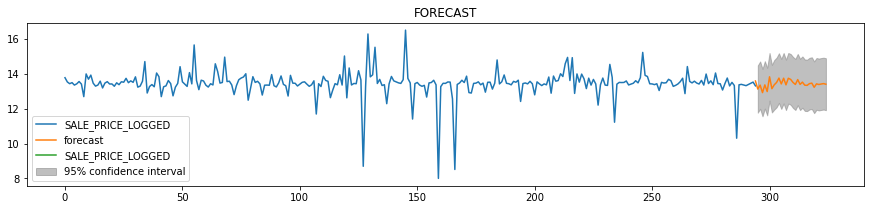

In [26]:
#plot of ARMA model
fig, ax = plt.subplots()
ax = df_price_date['SALE_PRICE_LOGGED'].plot(ax=ax, title='FORECAST')
fig = ar.plot_predict(294, 324, dynamic=True, ax=ax, plot_insample=True)
plt.show()

In [55]:
excel_df = pd.read_csv('NYC_Citywide_Rolling_Calendar_Sales.csv', usecols=['BOROUGH', 'SALE DATE', 'SALE PRICE'])
excel_df = excel_df[excel_df['BOROUGH']=='QUEENS']
# excel_df['SALE PRICE'].astype(int)

In [56]:
# excel_df['SALE PRICE'].astype(int)

# excel_df['SALE_PRICE_LOGGED'] = excel_df['SALE PRICE'].apply(lambda x : np.log(x))
excel_df.reset_index(drop=True, inplace=True)
# excel_df

In [57]:
excel_df['SALE PRICE'] = excel_df['SALE PRICE'].str.replace(',','')

In [58]:
excel_df['SALE PRICE'] = excel_df['SALE PRICE'].astype(int)

In [59]:
excel_df['SALE DATE'] = pd.to_datetime(excel_df['SALE DATE'])

In [60]:
excel_price_date = pd.DataFrame(excel_df, columns=['SALE DATE', 'SALE PRICE'])
excel_price_date = excel_price_date.set_index('SALE DATE')
# excel_price_date.dropna(inplace=True)

In [61]:
excel_price_date = excel_price_date.resample('D').mean()

In [63]:
excel_price_date = excel_price_date.fillna(0)
# excel_price_date

In [64]:
excel_price_date

,SALE PRICE
SALE DATE,
2020-05-01,5.120877e+05
2020-05-02,0.000000e+00
2020-05-03,0.000000e+00
2020-05-04,4.094063e+05
2020-05-05,6.187452e+05
...,...
2021-04-26,4.780256e+05
2021-04-27,3.857548e+05
2021-04-28,4.163778e+05


In [65]:
# excel_price_date.isnull().sum()
#  df = df[(df.T != 0).any()]
# excel_price_date = excel_price_date[(excel_price_date['SALE PRICE'] !=0)]

In [66]:
excel_price_date

,SALE PRICE
SALE DATE,
2020-05-01,5.120877e+05
2020-05-02,0.000000e+00
2020-05-03,0.000000e+00
2020-05-04,4.094063e+05
2020-05-05,6.187452e+05
...,...
2021-04-26,4.780256e+05
2021-04-27,3.857548e+05
2021-04-28,4.163778e+05


In [68]:
excel_price_date['SALE_PRICE_LOGGED'] = excel_price_date['SALE PRICE'].apply(lambda x : np.log(x))

In [69]:
excel_price_date

,SALE PRICE,SALE_PRICE_LOGGED
SALE DATE,,
2020-05-01,5.120877e+05,13.146251
2020-05-02,0.000000e+00,-inf
2020-05-03,0.000000e+00,-inf
2020-05-04,4.094063e+05,12.922463
2020-05-05,6.187452e+05,13.335449
...,...,...
2021-04-26,4.780256e+05,13.077420
2021-04-27,3.857548e+05,12.862957
2021-04-28,4.163778e+05,12.939348


C:\Users\booos\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:376: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'


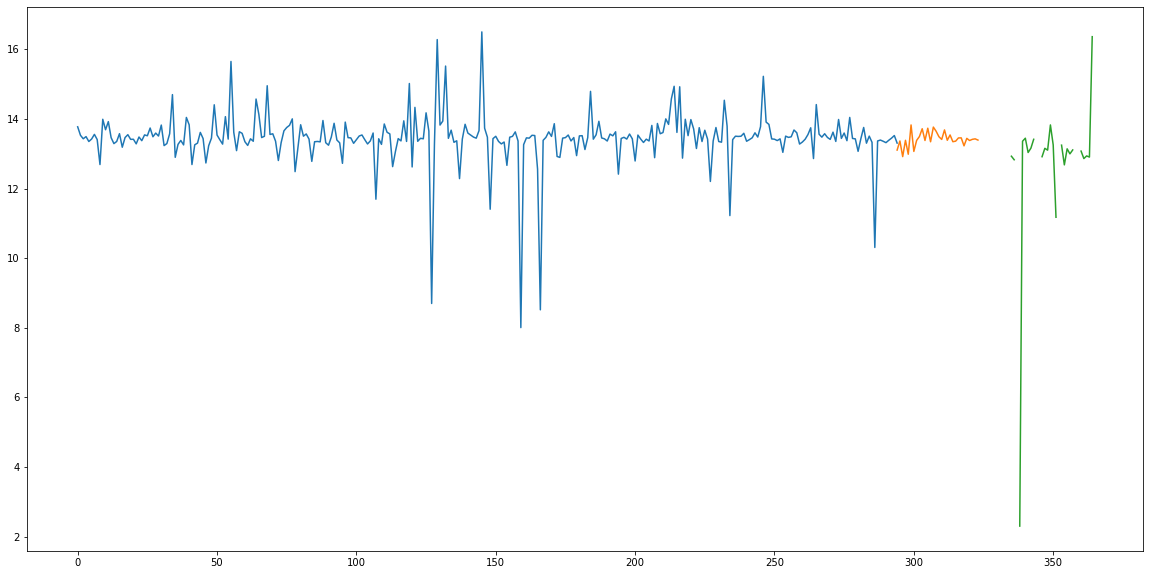

In [72]:
#plot of ARMA model
plt.figure(figsize=(20,10))
# figsize(20,10)

x1= range(0,295)
y1=df_price_date['SALE_PRICE_LOGGED']
plt.plot(x1,y1)
x2= range(294,324)
y2= ar.predict(295,324)
plt.plot(x2,y2)
x3= range(335,365)
y3=excel_price_date['SALE_PRICE_LOGGED'][335:365]
plt.plot(x3,y3)

In [53]:
excel_price_date['SALE_PRICE_LOGGED'][281:311]

SALE DATE
2021-03-25    13.165342
2021-03-26    13.062120
2021-03-27     0.105361
2021-03-29    13.610836
2021-03-30    13.215146
2021-03-31    13.270310
2021-04-01    12.931077
2021-04-02    12.828937
2021-04-04     2.302585
2021-04-05    13.361054
2021-04-06    13.447944
2021-04-07    13.037384
2021-04-08    13.162582
2021-04-09    13.416800
2021-04-12    12.916489
2021-04-13    13.157311
2021-04-14    13.104914
2021-04-15    13.829719
2021-04-16    13.254370
2021-04-17    11.176453
2021-04-19    13.248895
2021-04-20    12.681961
2021-04-21    13.143297
2021-04-22    12.998473
2021-04-23    13.111358
2021-04-26    13.077420
2021-04-27    12.862957
2021-04-28    12.939348
2021-04-29    12.906195
2021-04-30    16.365790
Name: SALE_PRICE_LOGGED, dtype: float64

In [44]:
y_predict = list(ar.predict(295,324))
len(y_predict)

C:\Users\booos\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:376: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'


30

In [54]:
ar.predict(295,324)

C:\Users\booos\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:376: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'


295    13.106593
296    13.368970
297    12.919370
298    13.387797
299    12.987500
300    13.829344
301    13.068461
302    13.385023
303    13.496048
304    13.720229
305    13.383093
306    13.735458
307    13.345873
308    13.767826
309    13.647684
310    13.491073
311    13.413067
312    13.686403
313    13.388459
314    13.541613
315    13.347802
316    13.363444
317    13.456090
318    13.457819
319    13.228984
320    13.443579
321    13.381723
322    13.416212
323    13.429893
324    13.394208
dtype: float64

In [51]:
y_test = list(excel_price_date['SALE_PRICE_LOGGED'][281:311])

In [52]:
len(y_test)

30